In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### First task: plot up a couple of haloes for a comparison plot

Whether this makes it into the paper or not is another issue, but could be a nice issue to explain points in the paper.

I will use the 'typical' example of the Milky Way.

In [53]:
import halo_modified

### Milky Way for reference #######

m_b_mw = [4e9] * u.Msun
delta_m_b_mw = [0] * u.Msun

m_d_mw = [5.3e10] * u.Msun
delta_m_d_mw = [0.5e10] * u.Msun

a_b_mw = [0.6] * u.kpc
delta_a_b_mw = [0] * u.kpc

R_d_mw = [2.15] * u.kpc
delta_R_d_mw = [0.14] * u.kpc

m_hi_mw = None
delta_m_hi_mw = None

mw_halo = halo_modified.TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,
                                  a_b_mw,delta_a_b_mw,R_d_mw,delta_R_d_mw,
                                  m_hi_mw,delta_m_hi_mw,
                                  None,None,None,None,1,0)

m_h = mw_halo.halo_mass()[0].data * u.Msun
m_h_hernquist = mw_halo.halo_mass_hernquist()[0].data * u.Msun
rho0_burkert = mw_halo.burkert_rho0()[0].nominal_value * (u.Msun/u.kpc**3)
R_h = mw_halo.halo_scale_length()[0].data * u.kpc

In [54]:
def hernquist_halo(M,a,r):
    return (M/(2*math.pi)) * (a/r) * (1/(r+a)**3)

def burkert_halo(rho0,a,r):
    return rho0 * a**3 / ((r+a)*(r**2+a**2))

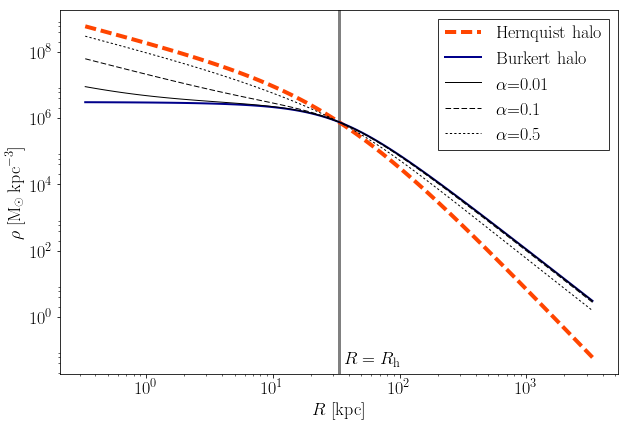

In [117]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

r = np.logspace(-2,2,100) * R_h.value
rho_h = hernquist_halo(m_h_hernquist.value,R_h.value,r)
rho_b = burkert_halo(rho0_burkert.value,R_h.value,r)

plt.sca(ax)
_ = ax.plot(r,rho_h,color='orangered',lw=4,linestyle='dashed',
            label='Hernquist halo')
_ = ax.plot(r,rho_b,color='darkblue',lw=2,
            label='Burkert halo')
_ = plt.axvline(R_h.value,lw=3,color='grey',zorder=-1)


styles = ('solid','dashed','dotted')
alphas = (0.01,0.1,0.5)

for style, alpha in zip(styles,alphas):
    rho = alpha * rho_h + (1-alpha)*rho_b
    _ = ax.plot(r,rho,color='k',linestyle=style,lw=1,
                label=r'$\alpha$={}'.format(alpha))

_ = ax.set_yscale('log')
_ = ax.set_xscale('log')
_ = ax.set_xlabel('$R$ [kpc]')
_ = ax.set_ylabel(r'$\rho$ [$\mathrm{M_\odot \, kpc^{-3}}$]')

_ = ax.legend(fancybox=False,edgecolor='k')

_ = ax.text(0.51,0.01,'$R=R_\mathrm{h}$',
            transform=ax.transAxes,ha='left',va='bottom')

#### Now, for the science part -- we should be able to calculate the required flattening to produce our spiral arm numbers.

In [119]:
def calculate_alpha(m_observed,m_burkert,m_hernquist):
    return (m_observed - m_burkert) / (m_hernquist - m_burkert)

def m_predicted(m_burkert,m_hernquist,alpha=1):
    return alpha * m_hernquist + (1-alpha) * m_burkert

In [120]:
masks = Table.read('fits/masks.fits')
morph_data = Table.read('fits/morph_data.fits')
halo_data = Table.read('fits/sdss_halo_table_matched.fits')
halo_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')

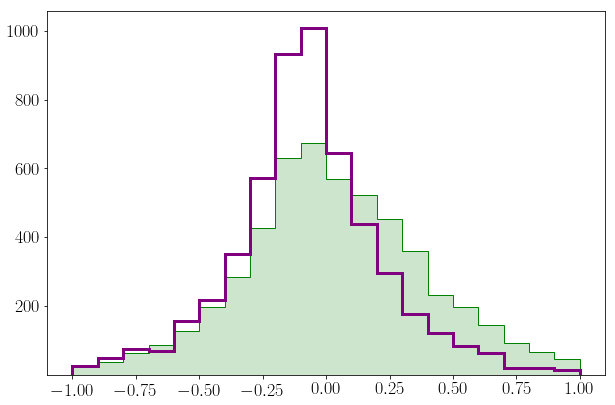

In [130]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

sample_ok = masks['z<0.085 (+HI unbarred spiral)']

bins = np.linspace(-1,1,21)

# Gassed
m_observed = morph_data['m_avg'][sample_ok]
m_burkert = halo_w_gas['m_burkert_2R_d'][sample_ok]
m_hernquist = halo_w_gas['m_hernquist_2R_d'][sample_ok]
alphas = calculate_alpha(m_observed,m_burkert,m_hernquist)
_ = ax.hist(alphas,bins,histtype='stepfilled',color='g',alpha=0.2)
_ = ax.hist(alphas,bins,histtype='step',color='g',lw=1)


# Gasless
m_observed = morph_data['m_avg'][sample_ok]
m_burkert = halo_data['m_burkert_2R_d'][sample_ok]
m_hernquist = halo_data['m_hernquist_2R_d'][sample_ok]
alphas = calculate_alpha(m_observed,m_burkert,m_hernquist)
_ = ax.hist(alphas,bins,histtype='step',color='purple',lw=3)